<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/Image_Segmentation_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmemtation Notes
In this notebook, we will learn about the ability of CNNs to preserve location of the objects. We will also learn upsampling and how FCNs can be used for semantic segmentation. 

In [0]:
import sys
import os
import tensorflow as tf

In [0]:
# Specify where you want to download the model to
checkpoints_dir = ''

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

# Download the model

In [0]:
!wget "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
!tar xvzf 'vgg_16_2016_08_28.tar.gz'

--2019-06-15 04:31:43--  http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.112.128, 2607:f8b0:4001:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.112.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 513324920 (490M) [application/x-tar]
Saving to: ‘vgg_16_2016_08_28.tar.gz.1’

vgg_16_2016_08_28.t 100%[===================>] 489.54M   136MB/s    in 3.6s    

2019-06-15 04:31:46 (136 MB/s) - ‘vgg_16_2016_08_28.tar.gz.1’ saved [513324920/513324920]

vgg_16.ckpt


# Set up the prerequisite library

In [0]:
!git clone https://github.com/tensorflow/models/
#os.chdir('models/research/slim')    
sys.path.append('models/research/slim')
os.getcwd()

fatal: destination path 'models' already exists and is not an empty directory.


'/content'

# Image Classification

The model that we have just downloaded was trained to be able to classify images into 1000 classes. The set of classes is very diverse. In our blog post we will use the pretrained model to classify, annotate and segment images into these 1000 classes.

Below you can see an example of Image Classification. We preprocess the input image by resizing it while preserving the aspect ratio and crop the central part. The size of the crop is equal to the size of images that the network was trained on.

W0615 04:32:00.334760 139706079557504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0615 04:32:00.586732 139706079557504 deprecation.py:323] From models/research/slim/preprocessing/vgg_preprocessing.py:249: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0615 04:32:00.603399 139706079557504 deprecation_wrapper.py:119] From models/research/slim/preprocessing/vgg_preprocessing.py:256: The name tf.rint is deprecated. Please use tf.math.rint instead.

W0615 04:32:00.605802 139706079557504 deprecation.py:323] From models/research/slim/preprocessing/vgg_pr

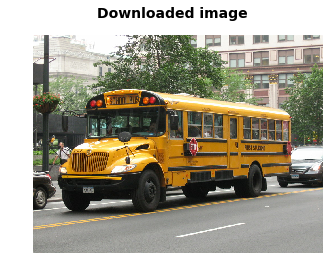

W0615 04:32:09.848737 139706079557504 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


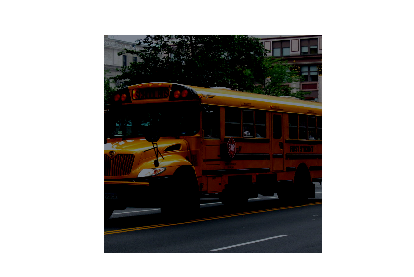

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [0]:
from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
from six.moves import urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/content'

slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    # Open specified url and load image as a string
    image_string = urllib.request.urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of the network.
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    
    # Networks accept images in batches.
    # The first dimension usually represents the batch size. In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model with the fully connected layers for classification
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Function to reload the model
    reload_model = slim.assign_from_checkpoint_fn( os.path.join(checkpoints_dir, 'vgg_16.ckpt'), slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        # Load weights
        reload_model(sess)
        
        # We want to get predictions, image as numpy matrix and preprocessed image too
        np_image, network_input, probabilities = sess.run([image, processed_image, probabilities])
        
        probabilities = probabilities[0,:]
        
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x: x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the preprocessed_image
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to the network", color = 'w', fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()

# Image Segmentation

For the simplicity, the segmentation will be of a smaller size than the original image. We can do segmentation using an existing Convolutional Neural Network by applying it in a Fully Convolutional manner. This is done by casting the Fully Connected Layers of a network into Convolutional -- this way we can input image of any size and get segmentation of lower resolution due to max-pooling layers that are used in network.

W0615 04:32:10.770164 139706079557504 deprecation.py:506] From <ipython-input-9-b9d061927bb8>:53: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


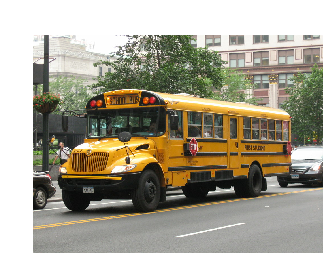

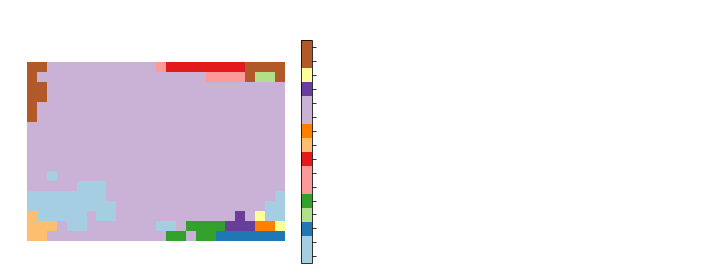

In [0]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)

# Function to print segmentation results with colorbar showing class names
def show_segmentation(data, labels_names=[], title=""):

    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    
    # set limits .5 outside true range
    mat = plt.matshow(data, cmap=cmap, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    
    # arrange the color bar in increasing order
    color_bar = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        color_bar.ax.set_yticklabels(labels_names, color = 'w')
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold', color = 'w')
        
    plt.axis('off')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib.request.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the mean pixel value
    image_float = tf.to_float(image, name='to_float')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,[_R_MEAN, _G_MEAN, _B_MEAN])

    # Expand the image dimension to feed it into a network 
    input_image = tf.expand_dims(processed_image, axis = 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully convolutional manner
        logits, _ = vgg.vgg_16(input_image, num_classes=1000, is_training=False, spatial_squeeze=False)
    
    # For each pixel we get predictions for each class out of 1000. We need to pick the one with the highest probability. 
    # To be more precise, these are not probabilities, because we didn't apply softmax. But if we pick a class 
    # with the highest value it will be equivalent to picking the highest value after applying softmax
    pred = tf.argmax(logits, dimension = 3)
    
    restore_model = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'vgg_16.ckpt'), slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        restore_model(sess)
        mask, np_image = sess.run([pred, image])

# Remove the first empty dimension
mask = np.squeeze(mask)

# Let's get unique predicted classes (from 0 to 1000) and relable the original predictions so that classes arenumerated starting from zero
unique_classes, segmentation = np.unique(mask, return_inverse=True)

segmentation_size = mask.shape

segmentation = segmentation.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):
    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontweight='bold', color = 'w')
plt.axis('off')
plt.show()

show_segmentation(data = segmentation, labels_names=labels_names, title="Segmentation")

The segmentation that was obtained shows that network was able to find the school bus, traffic sign in the left-top corner that can't be clearly seen in the image. It was able to locate windows at the top-left corner and even made a hypothesis that it is a library (we don't know if that is true). It also made a certain number of not so correct predictions. Those are usually caused by the fact that the network can only see a part of image when it is centered at a pixel. The characteristic of a network that represents it is called receptive field. Receptive field of the network that we use in this blog is 404 pixels. So when network can only see a part of the school bus, it confuses it with taxi or pickup truck. You can see that in the bottom-left corner of segmentation results.

As we can see above, we got a simple segmentation for our image. It is not very precise because the network was originally trained to perform classification and not segmentation. If we want to get better results, we will have to train it ourselves. Anyways, the results that we got are suitable for image annotation and very approximate segmentation.

Performing Segmentation using Convolutional Neural Networks can be seen as performing classification at different parts of an input image. We center network at a particular pixel, make prediction and assign label to that pixel. This way we add spatial information to our classification and get segmentation.

# Image Upsampling

In this post, we will perform image upsampling to get the prediction map that is of the same size as an input image. We will do this using transposed convolution (also known as deconvolution). The most accurate name for the kind of operation that we will perform in this post is fractionally strided convolution.

The idea behind resampling is to reconstruct the continuous signal from the original sampled signal and resample it again using more samples (which is called interpolation or upsampling) or fewer samples (which is called decimation or downsampling)
In other words, we can approximate the continious signal from the points that we have and sample new ones from the reconstructed signal. So, to be more specific, in our case, we have downsampled prediction map -- these are points from which we want to reconstruct original signal. And if we are able to approximate original signal, we can sample more points and, therefore, perform upsampling.

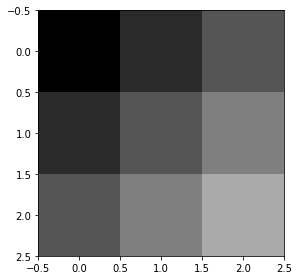

In [0]:
from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


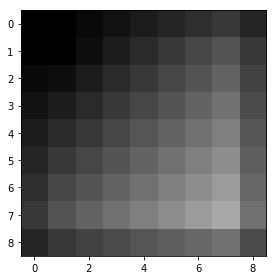

In [0]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img, factor, mode='constant', cval=0, order=1)

upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

# Function to perform upsampling

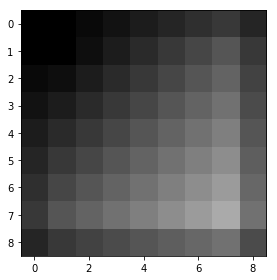

In [0]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor, number_of_classes)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                                 output_shape=[1, new_height, new_width, number_of_classes],
                                 strides=[1, factor, factor, 1])

                final_result = sess.run(res, feed_dict={upsample_filt_pl: upsample_filter_np,
                                             logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

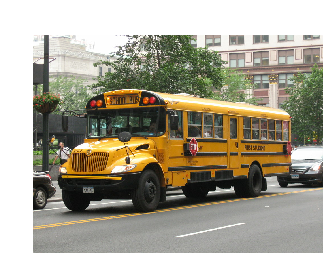

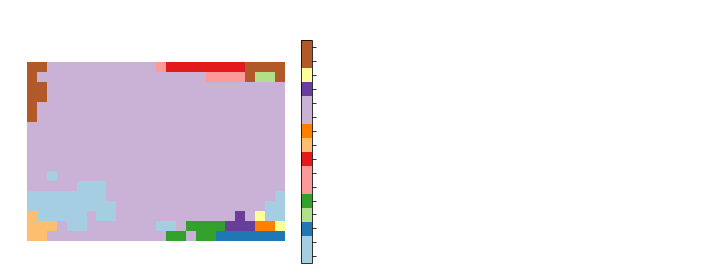

In [0]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)

# Function to print segmentation results with colorbar showing class names
def show_segmentation(data, labels_names=[], title=""):

    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    
    # set limits .5 outside true range
    mat = plt.matshow(data, cmap=cmap, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    
    # arrange the color bar in increasing order
    color_bar = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        color_bar.ax.set_yticklabels(labels_names, color = 'w')
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold', color = 'w')
        
    plt.axis('off')
    plt.show()


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib.request.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the mean pixel value
    image_float = tf.to_float(image, name='to_float')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,[_R_MEAN, _G_MEAN, _B_MEAN])

    # Expand the image dimension to feed it into a network 
    input_image = tf.expand_dims(processed_image, axis = 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully convolutional manner
        logits, _ = vgg.vgg_16(input_image, num_classes=1000, is_training=False, spatial_squeeze=False)
    
    # For each pixel we get predictions for each class out of 1000. We need to pick the one with the highest probability. 
    # To be more precise, these are not probabilities, because we didn't apply softmax. But if we pick a class 
    # with the highest value it will be equivalent to picking the highest value after applying softmax
    pred = tf.argmax(logits, dimension = 3)
    
    restore_model = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'vgg_16.ckpt'), slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        restore_model(sess)
        mask, np_image, np_logits = sess.run([pred, image, logits])

# Remove the first empty dimension
mask = np.squeeze(mask)

names = imagenet.create_readable_names_for_imagenet_labels()

# Let's get unique predicted classes (from 0 to 1000) and relable the original predictions so that classes arenumerated starting from zero
unique_classes, segmentation = np.unique(mask, return_inverse=True)

segmentation_size = mask.shape

segmentation = segmentation.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):
    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontweight='bold', color = 'w')
plt.axis('off')
plt.show()

show_segmentation(data = segmentation, labels_names=labels_names, title="Segmentation")

# Upsample the segmentation map

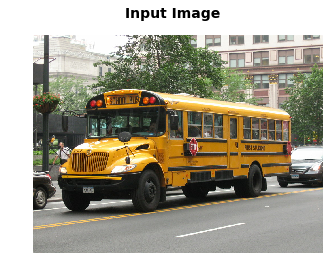

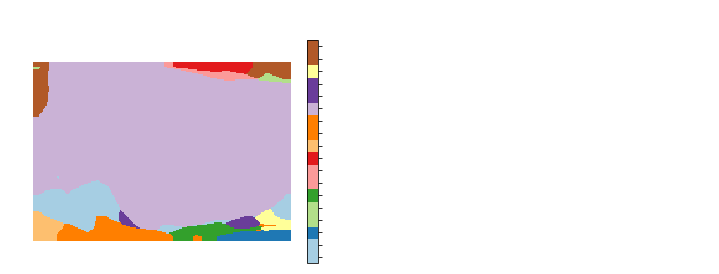

In [0]:
upsampled_logits = upsample_tf(factor=8, input_img = np_logits.squeeze())
upsampled_predictions = upsampled_logits.squeeze().argmax(axis=2)

unique_classes, relabeled_image = np.unique(upsampled_predictions,
                                            return_inverse=True)

relabeled_image = relabeled_image.reshape(upsampled_predictions.shape)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

show_segmentation(data=relabeled_image, labels_names=labels_names, title="Segmentation")

The ouput results that we got are quite noisy, but we got an approximate segmentation for the bus. To be more precise, it is not a segmentation but regions where the network was evaluated and gave the following predictions.

We covered the transposed convolution and specifically the implementation of bilinear interpolation using transposed convolution. We applied it to downsampled predictions to upsample them and get predictions for the whole input image.

# Training the network to perform image segmentation

In [0]:
!wget https://github.com/warmspringwinds/tensorflow_notes/raw/master/data/imgs/cat.jpg
!wget https://github.com/warmspringwinds/tensorflow_notes/raw/master/data/imgs/cat_annotation.png    

--2019-06-15 04:32:30--  https://github.com/warmspringwinds/tensorflow_notes/raw/master/data/imgs/cat.jpg
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/warmspringwinds/tensorflow_notes/master/data/imgs/cat.jpg [following]
--2019-06-15 04:32:30--  https://raw.githubusercontent.com/warmspringwinds/tensorflow_notes/master/data/imgs/cat.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35603 (35K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  34.77K  --.-KB/s    in 0.01s   

2019-06-15 04:32:30 (3.55 MB/s) - ‘cat.jpg’ saved [35603/35603]

--2019-06-15 04:32:32

In [0]:
def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [0]:
from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

image_filename = 'cat.jpg'
annotation_filename = 'cat_annotation.png'

image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}

image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0. 
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis=2, values=[bit_mask_class, bit_mask_background])

# Lets reshape our input so that it becomes suitable for 
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor = combined_mask, shape=(-1, 2))

W0615 04:32:34.420608 139706079557504 deprecation.py:323] From <ipython-input-18-c6166d67543e>:69: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



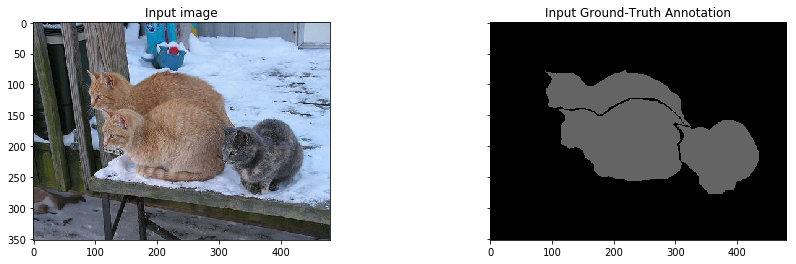

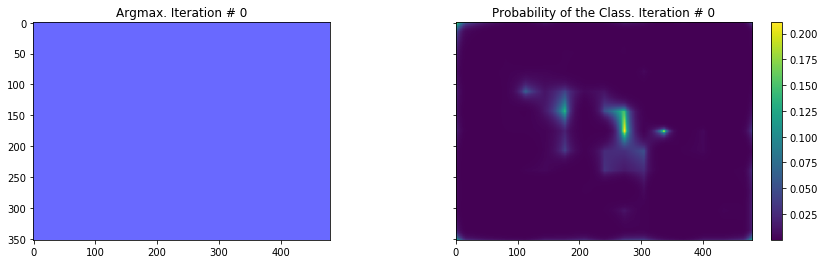

Current Loss: [229007.17]


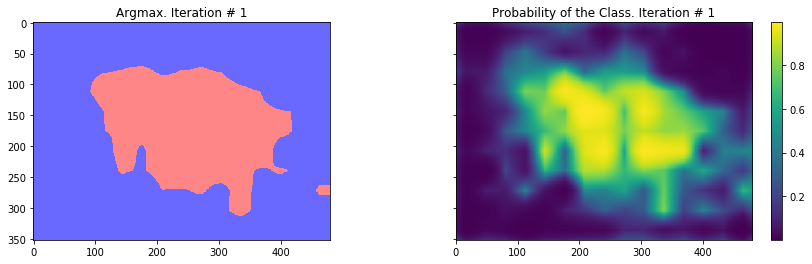

Current Loss: [211731.75]


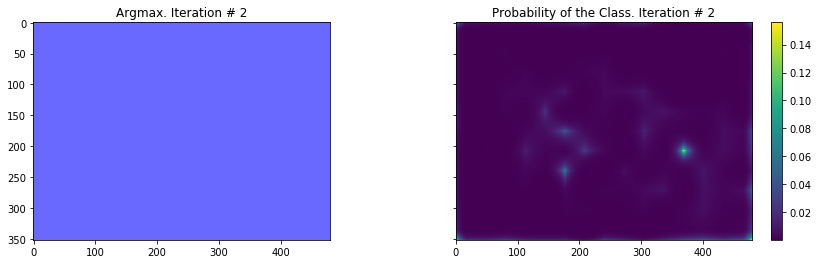

Current Loss: [49004.67]


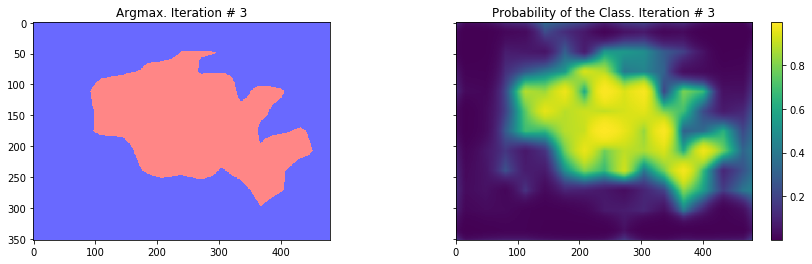

Current Loss: [224480.48]


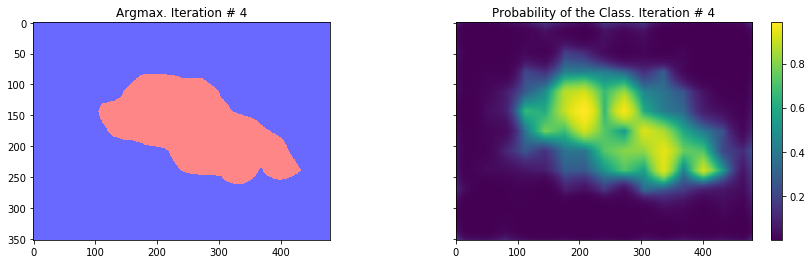

Current Loss: [47357.742]


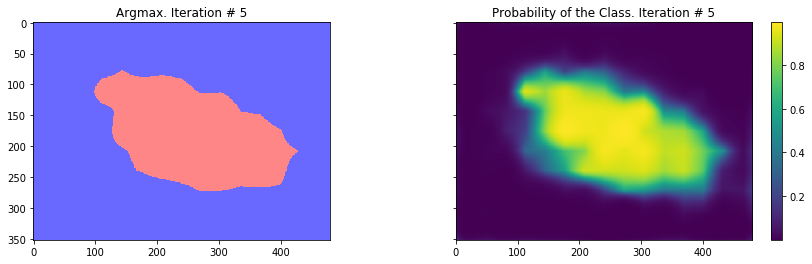

Current Loss: [32995.85]


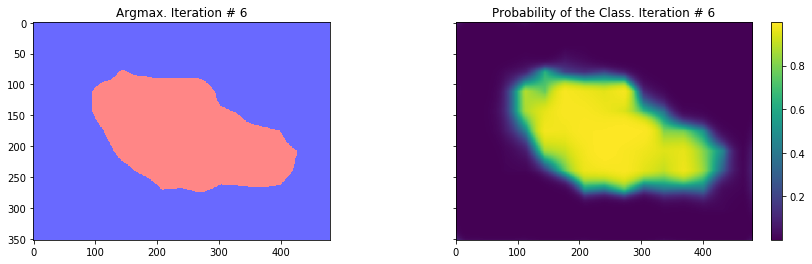

Current Loss: [28088.645]


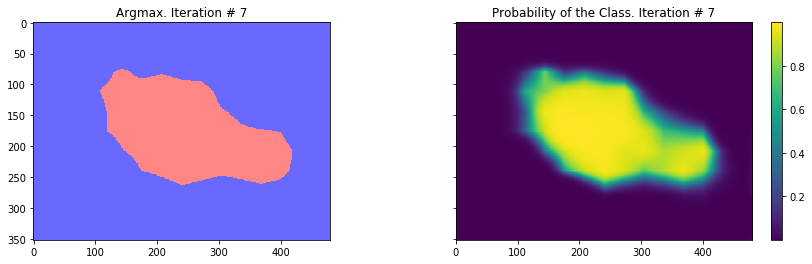

Current Loss: [23558.953]


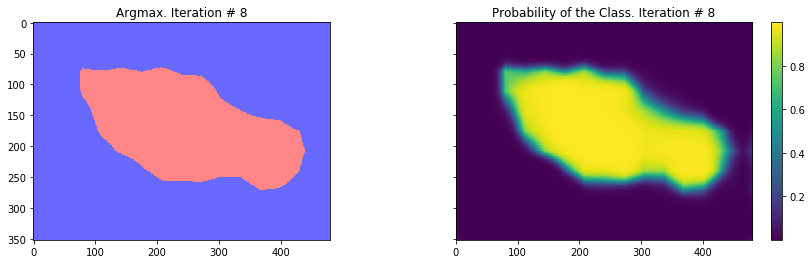

Current Loss: [19659.018]


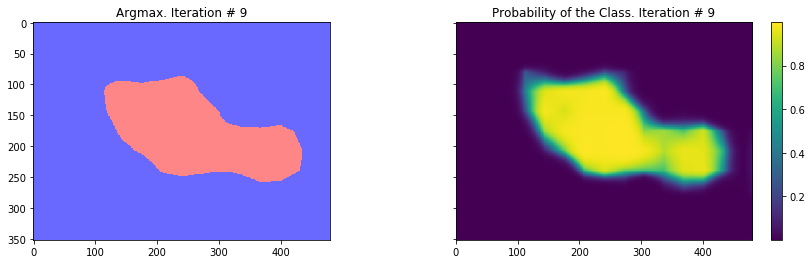

Current Loss: [19190.883]


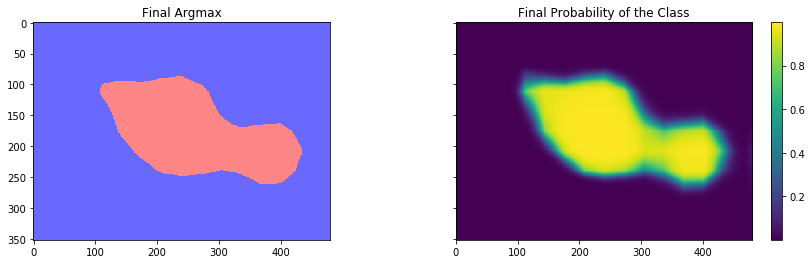

Final Loss: 22182.086


In [0]:
import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

slim = tf.contrib.slim

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 10
number_of_classes = 2

vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float, [_R_MEAN, _G_MEAN, _B_MEAN])

processed_images = tf.expand_dims(mean_centered_image, 0)

# create weight matrix for transposed convolution
upsample_filter_np = bilinear_upsample_weights(upsample_factor, number_of_classes)

# convert the weights into a tensor
upsample_filter_tensor = tf.constant(upsample_filter_np)

# Define the model with only 2 classes
# Here 'spatial_squeeze = False' specifies that we are not using fully connected layers
with slim.arg_scope(vgg.vgg_arg_scope()):
    
    logits, end_points = vgg.vgg_16(processed_images, num_classes=2, is_training=is_training_placeholder, spatial_squeeze=False, fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.stack([
                                  downsampled_logits_shape[0],
                                  downsampled_logits_shape[1] * upsample_factor,
                                  downsampled_logits_shape[2] * upsample_factor,
                                  downsampled_logits_shape[3]
                                 ])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor, output_shape = upsampled_logits_shape, strides=[1, upsample_factor, upsample_factor, 1])

# Flatten the predictions, so that we can compute cross-entropy for each pixel and get a sum of cross-entropies.
flat_logits = tf.reshape(tensor = upsampled_logits, shape=(-1, 2))

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay attention that we don't need softmax in this case because
# we only need the final decision. If we also need the respective probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, dimension=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later. Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of our variables. This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Replace some characters from the original variable name tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_") 
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Create an OP that performs the restoration of variables
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(vgg_checkpoint_path,vgg_except_fc8_weights)

# Randomly initialise the new fc8 weights
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Randomly initialise the adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor], feed_dict=feed_dict_to_use)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    # Let's perform 10 interations
    for i in range(10):
        
        loss = sess.run([cross_entropy_sum],
                                        feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities], feed_dict=feed_dict_to_use)
        
        cmap = plt.get_cmap('bwr')
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " +  str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    plt.show()
    
    print("Final Loss: " +  str(final_loss))

As you can see, the results are very coarse -- and these are results that we get by running our network on the same image that we were training on. This is very common problem in segmentation -- the results are usually coarse. There are different approaches that can help to solve this problem -- one of them is to use skip-connections. The main idea is that predictions are made by fusing predictions from different layers of the network. Because in earlier layers of a network the downsampling factor is smaller, it is possible to get a better localization by making predictions based on those layers. This approach is described in the Fully convolutional networks for semantic segmentation by Long et al. This approach gave rise to FCN-16s and FCN-8s architectures.

Another approach is based on using atrous convolutions and fully connected conditional random fields. The approach is described in the Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs by Chen et al. In this post we will only use CRF post-processing stage to show how it can improve the results.

# Conditional Random Field post-processing
Conditional Random Field is a specific type of graphical model. In our case it helps to estimate the posterior distribution given predictions from our network and raw RGB features that are represented by our image. It does that by minimizing the energy function which are defined by the user. In our case the effect is very similar to bilateral filter which takes into account the spatial closeness of pixels and their similarity in RGB feature space (intensity space).

On a very simple level, it uses RGB features to make prediction more localized -- for example the border is usually represented as a big intensity change -- this acts as a strong factor that objects that lie on different side of this border belong to different classes. It also penalizes small segmentation regions -- for example it is unlikely that a small region of 20 or 50 pixels is a correct segmentation. Objects are usually represented by big spatially adjacent regions.

Below you can see how this post-processing stage affects our results. We are using fully connected conditional random fields which is described in Efficient inference in fully connected crfs with gaussian edge potentials paper.

W0615 04:38:03.907804 139706079557504 utils.py:84] pydensecrf.softmax_to_unary is deprecated, use unary_from_softmax instead.


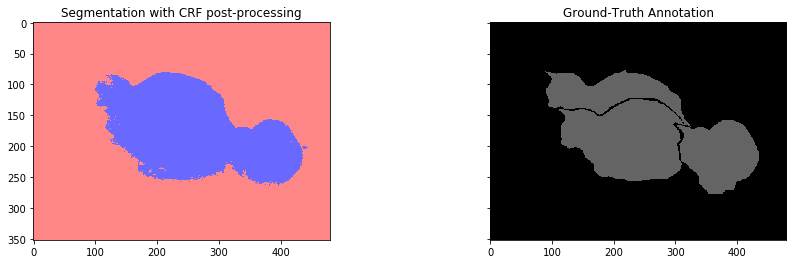

In [0]:
!pip install pydensecrf
import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, softmax_to_unary

import skimage.io as io

image = train_image

softmax = final_probabilities.squeeze()

softmax = softmax.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(softmax)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()